<a href="https://colab.research.google.com/github/eliabrodsky/bioinformatics/blob/main/Results_Breast_Cancer_Cell_Lines_Feature_Selection_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the Notebook

In [ ]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import pandas and numpy
import pandas as pd
import numpy as np

#PCA
from sklearn.decomposition import PCA 

#import standard classification tools from sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import itertools

#classification model
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

template = 'ggplot2'

# Import and Prepare Data

In [ ]:
#load data
data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/CellLines_52samples_ExprData_T1.txt',sep='\t',header=(0))
features = data.iloc[1:, 0].values

#add the gene id to index column
data.index = data.id

#drop or remove "id" column from the data
data=data.drop(['id'], axis = 1) 

#transpose
dataT = np.transpose(data)

#prepare train and test data
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

#save class names
classes = np.unique(y)
n_classes = len(classes)
cat = dataT['class']

#prepare train and test data (try changing test_size, enable/disable stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify = y)

#print out test class proportion from total
for i in range(len(classes)):
  print(classes[i], y_test.tolist().count(classes[i]), "/", y.tolist().count(classes[i]))

Basal 6 / 14
Claudin-low 2 / 6
Luminal 11 / 27
Normal-like 2 / 5


In [ ]:
dataT = dataT.drop(columns=['class'])
dataT.head()

id,ENSG00000000419,ENSG00000001036,ENSG00000001084,ENSG00000001497,ENSG00000001617,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,ENSG00000002586,...,ENSG00000269871,ENSG00000269893,ENSG00000269897,ENSG00000269900,ENSG00000269968,ENSG00000270016,ENSG00000270149,ENSG00000270161,ENSG00000270168,ENSG00000270170
184A1,6.06,4.47,4.47,5.27,6.05,6.24,4.17,6.55,5.19,7.12,...,7.34,7.89,5.4,5.28,5.74,0.04,4.39,4.09,2.17,3.99
184B5,5.25,5.39,6,4.27,7.31,5.26,3.51,7.49,4.54,6.53,...,7.53,8.44,5.19,0,5.92,0,4.98,3.9,1.6,4.65
21MT1,5.15,5.28,5.77,6.58,3.99,5.67,3.86,5.69,4.64,6.17,...,7.43,4.7,5.27,5.99,1.91,0,4.78,6.49,2.7,5.92
21NT,5.36,5.82,5.76,5.54,5.93,6.11,5.12,5,4.64,6.76,...,7.61,5.24,5.54,7.25,2.1,0.16,5.07,6.22,3.12,5.89
21PT,5.22,5.75,5.76,5.57,5.98,5.77,4.75,4.9,4.81,6.64,...,7.57,4.8,5.33,7.6,2.66,0,4.81,6.35,3.79,5.97


In [ ]:
#Run Principal Component Analysis
pca = PCA(n_components=3) 

pca.fit(dataT) 
xpca = pca.transform(dataT)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Class", color=cat,
                       template="plotly_white", height=800, width=800)
figPCA.show()

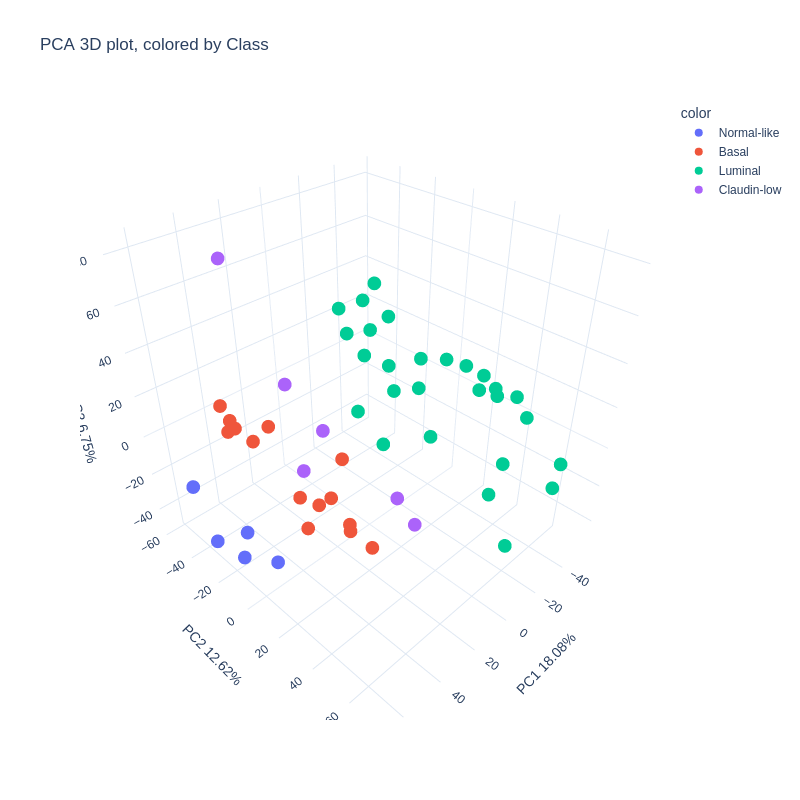

In [ ]:
from IPython.display import Image

img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)
Image(img_bytes)

# Random Forest

In [ ]:
#define Random forest model
model = RandomForestClassifier(n_estimators = 100, 
                               max_depth = 500, 
                               verbose=False,
                               random_state=0)

#fit model on training data
model.fit(X_train, y_train)

#Predict test data
predictions = model.predict(X_test)
print("Model accuracy = ", accuracy_score(y_test, predictions))

Model accuracy =  0.8571428571428571


In [ ]:
#define Random forest model
model = RandomForestClassifier(n_estimators = 1000, 
                               max_depth = 5000,
                               bootstrap=True, 
                               verbose=False,
                               random_state=0)

#fit model on training data
model.fit(X_train, y_train)

#Predict test data
predictions = model.predict(X_test)
print("Model accuracy = ", accuracy_score(y_test, predictions))

Model accuracy =  1.0


## Confusion Matrix

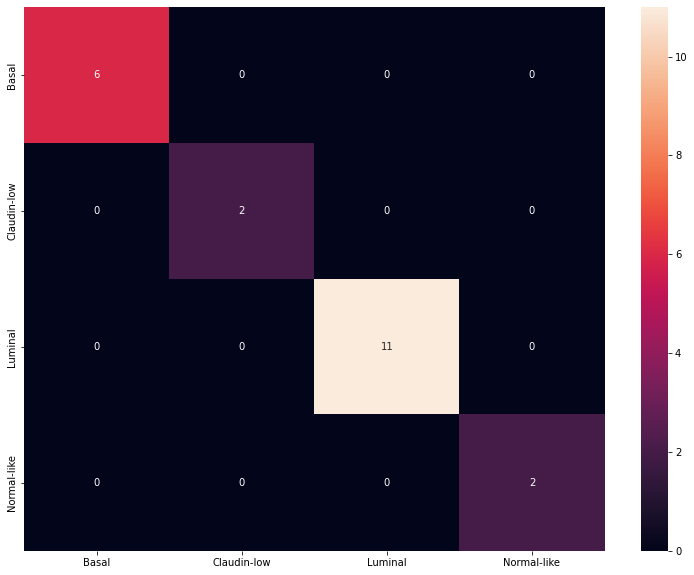

In [ ]:
#prepare a confusion matrix
conf = confusion_matrix(y_test,predictions)
new_conf = pd.DataFrame(conf, columns=classes, index=classes)

#plot heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(new_conf, annot=True);

##Feature Importance

total number of selected features:  57


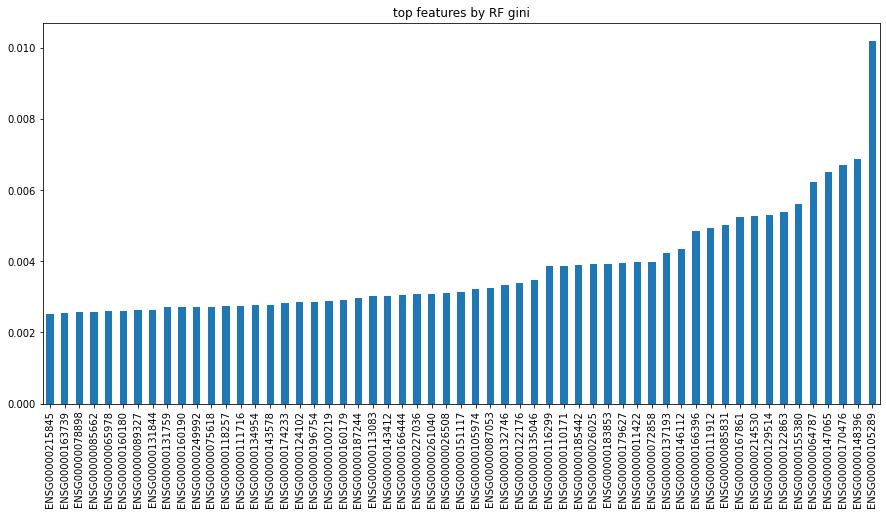

In [ ]:
#prepare the list of significant features
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

#select top features and save them
forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances[forest_importances > 0.0025]
forest_importances = forest_importances.sort_values()

#plot forest_importances
forest_importances.plot.bar(figsize=(15, 7), title="top features by RF gini");

#print
print("total number of selected features: ", len(forest_importances))

# PCA


In [ ]:
selected_features = forest_importances.index.tolist()

dataT1 = dataT[dataT.columns.intersection(selected_features)]
print("new dimensions of select features: ", dataT1.shape)

#Run Principal Component Analysis
pca = PCA(n_components=3) 
pca.fit(dataT1) 
xpca = pca.transform(dataT1)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Class", color=cat,
                       template="plotly_white", height=600, width=800)
figPCA.show()

new dimensions of select features:  (52, 57)


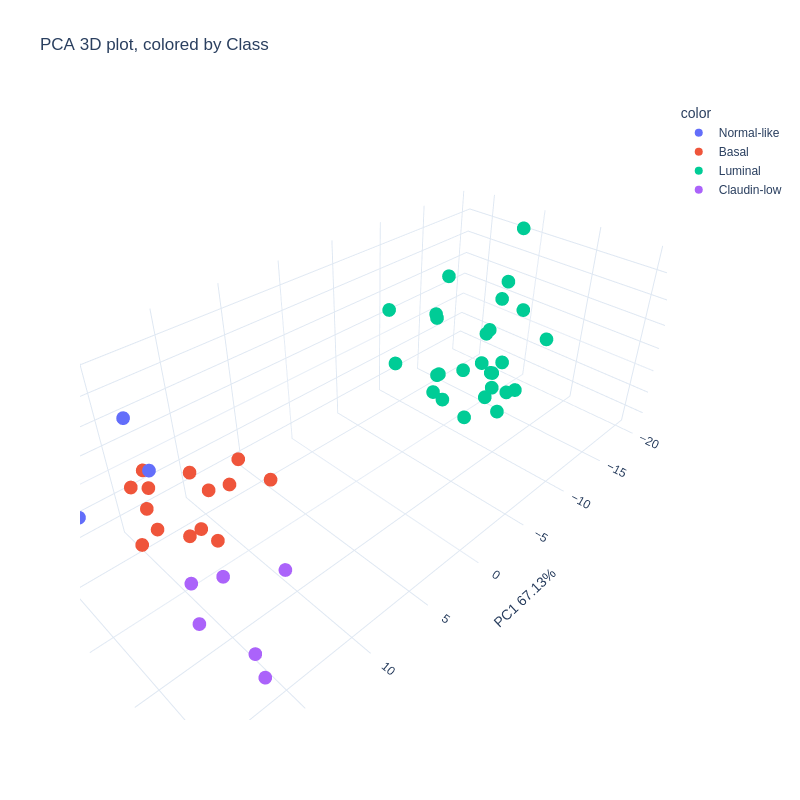

In [ ]:
img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)
Image(img_bytes)

# Questions for Reflection:
How did hyperparameters change accuracy of the model?
How many significant genes did we use for PCA?
How did the 'variance explained' of the PCA improve after feature selection?